### A Content Based Image Retrieval Pipeline

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.metrics.pairwise import euclidean_distances,cosine_distances
import collections
import os

### Import Dataset

In [2]:
def get_name(filename):
    i = filename.rfind('/')
    j = filename.rfind('.')
    return filename[i+1:j]

In [3]:
def get_image(filename):
    return cv2.resize(cv2.cvtColor(cv2.imread(filename),
                                   cv2.COLOR_BGR2GRAY).astype('uint8'),
                      (256,256))

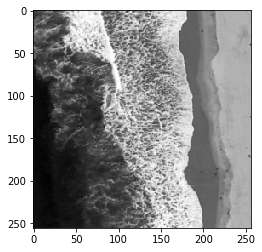

In [4]:
file_directory = "./Smaller_Dataset/**/*.tif"

all_files = glob.glob(file_directory)

all_images = {get_name(file):get_image(file) for file in all_files}
plt.imshow(all_images['beach03'],cmap='gray')


In [5]:
# This function extracts all the true similar images, or in other words the ground 
# truth for a particular query. In the case of this dataset it is the images of the
# same class

def get_true_similar(query):
    base_name = ''.join([char for char in query if not char.isdigit()])
    true_similar = {file:image for file, image in all_images.items() if base_name in file}
#     for file, image in all_images.items():
#         if base_name in file:
#             true_similar.append((file, image))
    
    return true_similar

Similar images to image 'river03' are as follows


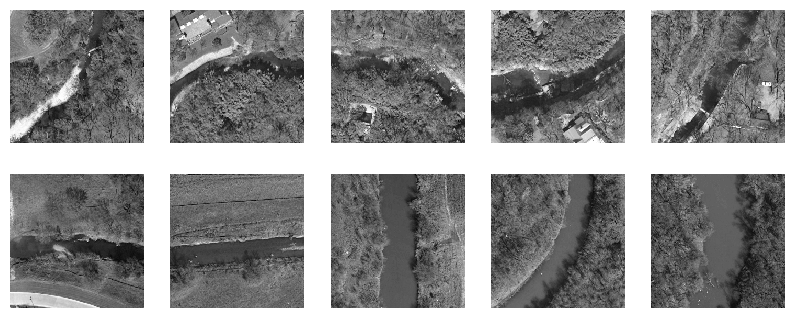

In [6]:
# Testing the get_true_similar function        
true_rivers = [image for key, image in get_true_similar('river03').items()]
# There will always be 10 similar images to a particular query image
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(true_rivers[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
print("Similar images to image 'river03' are as follows")

### Feature Extraction

In [7]:
def split_image(image, factor):
    new_height = int(image.shape[1]/2)
    new_width = int(image.shape[0]/2)
    images = []
    images.append(image[0:new_height, 0:new_width])
    images.append(image[0:new_height, new_width:])
    images.append(image[new_height:, 0:new_width])
    images.append(image[new_height:, new_width:])
    if(factor <= 1):
        return images
    else:
        to_return = []
        for image in images:
            splits = split_image(image, factor-1)
            for split in splits:
                to_return.append(split)
        return to_return
            
def local_histogram(image, reduce_factor = 2):
    splits = split_image(image, reduce_factor)
    histograms = [cv2.calcHist(img,[0],None,[256],[0, 256]).flatten() for img in splits]
    flattened_hist = np.array([value for hist in histograms for value in hist])
#     fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10), dpi=100)
#     for i, ax in enumerate(axes.flatten()):
#         ax.imshow(splits[i], cmap='gray')
#         ax.grid(False)
#         ax.axis('off')
    return flattened_hist

In [8]:
os.path.exists('./vocabulary_sift.pkl')

False

In [9]:
def generate_vocabulary(features_db,vocab_size=1028):
    if os.path.exists('./vocabulary_sift.npy'):
        return np.load('./vocabulary_sift.npy',allow_pickle=True)
    else:
        bovw = cv2.BOWKMeansTrainer(vocab_size)
        for (filename,features) in features_db.items():
            bovw.add(features)
        vocabulary = bovw.cluster()
        np.save('./vocabulary_sift',vocabulary,allow_pickle=True)
        return vocabulary

#Represents an image using the vocabulary built through Bag of Visual Words. Each feature is assigned using hard assignment
def image_bovw(all_images_fv,vocabulary, desc='sift'):
    if os.path.exists('./imgs_rep_vocab'):
        return np.load('./imgs_rep_vocab',allow_pickle=True)
    else:
        num_images = len(all_images_fv)
        vocab_size = len(vocabulary)
        imgs_rep_vocab = np.zeros((vocab_size,128,num_images))
        print(f"Created a 3D matrix of: ${imgs_rep_vocab.shape}")
        imgs_rep_vocab[:vocab_size,:128,:] = np.expand_dims(np.copy(vocabulary),axis=-1)
        for (index,key) in enumerate(all_images_fv):
            image_fv = all_images_fv[key]
            for fv in image_fv:
                nearest_feature_index = np.linalg.norm(vocabulary-fv).argmin()
                imgs_rep_vocab[nearest_feature_index,:,index]+=1.0
        np.save('./imgs_rep_vocab',imgs_rep_vocab,allow_pickle=True)
        return imgs_rep_vocab

#Convert 3D matrix to standard dictionary structure as used for other feature descriptors
def cube_to_dict(feature_matrix,all_images):
    features_dict = {}
    for index,key in enumerate(all_images):
        features_dict[key] = feature_matrix[:,:,index]
    return features_dict

In [10]:
def get_features(all_images,descriptor='hist'):
    all_features = {}
    if descriptor=='hist':
        all_features = {filename:cv2.calcHist(img,[0],None,[256],[0, 256]).flatten() for (filename,img) in all_images.items()}
    elif descriptor=='sift':
        sift = cv2.xfeatures2d.SIFT_create()
        all_features = {filename:sift.detectAndCompute(img,None)[1] for (filename,img) in all_images.items()}
        vocab = generate_vocabulary(all_features)
        bovw_rep = image_bovw(all_features,vocab)
        all_features = cube_to_dict(bovw_rep,all_images)
    elif descriptor=='hog':
        hog = cv2.HOGDescriptor()
        all_features = {filename:hog.compute(img).flatten() for (filename,img) in all_images.items()}
    elif descriptor=='local_hist':
        all_features = {filename:local_histogram(img) for (filename, img) in all_images.items()}
    else:
        print("Incorrect descriptor")
    return all_features

In [11]:
# For any given image the feature vector should be the same shape. Testing for Histograms
features_hist = get_features(all_images,descriptor='hist')
print(features_hist['river03'].shape)
print(features_hist['beach01'].shape)

(256,)
(256,)


In [12]:
# Test if HOG features work or not
features_hog = get_features(all_images, descriptor='hog')
print(features_hog['river03'].shape)
print(features_hog['beach01'].shape)
for k, v in features_hog.items():
    if(v.shape[0] != 1606500):
        print(k, ":", v.shape)

(1606500,)
(1606500,)


In [13]:
#Test if Local Histogram features have same shape
features_local_hist = get_features(all_images, descriptor='local_hist')
print(features_local_hist['river03'].shape)
print(features_local_hist['beach01'].shape)

(4096,)
(4096,)


In [14]:
#Test SIFT features represented through Bag of Visual Words -- Default Vocabulary size is: 1028. Expecting 1028x128 representation for all images
features_sift = get_features(all_images, descriptor='sift')
print(features_sift['river03'].shape)
print(features_sift['beach01'].shape)

Created a 3D matrix of: $(1028, 128, 210)
(1028, 128)
(1028, 128)


### Similarity Computation

In [15]:
def compute_similarity(query_img_fv,features_db,dist='cosine'):
    all_similarity = None
    if dist == 'cosine':
        all_similarity = {filename:cosine_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    elif dist == 'euclidean':
        all_similarity = {filename:euclidean_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    
    #Sort Results
    sorted_all_similarity = sorted(all_similarity.items(), key=lambda kv: kv[1])
    sorted_all_similarity = collections.OrderedDict(sorted_all_similarity)
    return sorted_all_similarity

Retrieved images Similar to image 'river03' are as follows


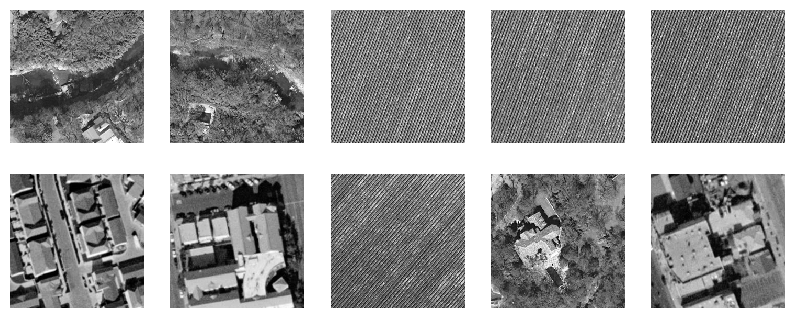

In [16]:
# Testing the Compute Similarity Function - Histogram Features
similarity_scores = compute_similarity(features_hist['river03'],features_hist, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images Similar to image 'river03' are as follows")

Retrieved images Similar to image 'river03' are as follows


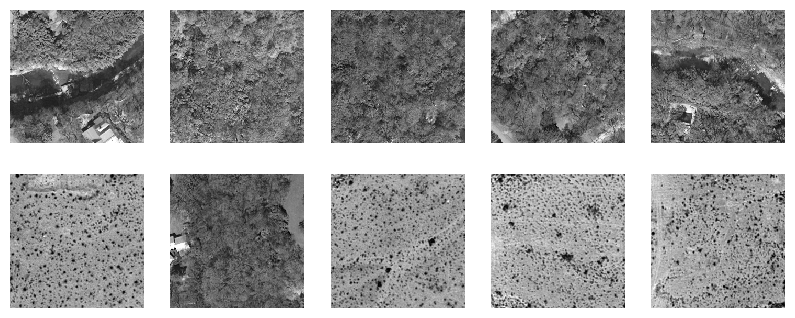

In [17]:
# Testing the Compute Similarity Function - HOG features
similarity_scores = compute_similarity(features_hog['river03'],features_hog, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images Similar to image 'river03' are as follows")

Retrieved images Similar to image 'river03' are as follows


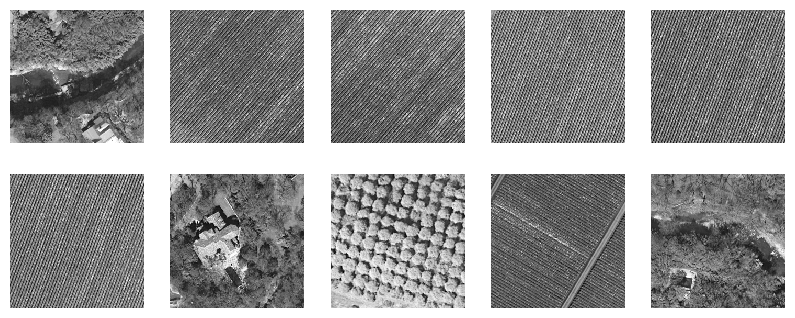

In [18]:
# Testing the Compute Similarity Function - Local Histogram features
similarity_scores = compute_similarity(features_local_hist['river03'],features_local_hist, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images Similar to image 'river03' are as follows")

Retrieved images Similar to image 'river03' are as follows


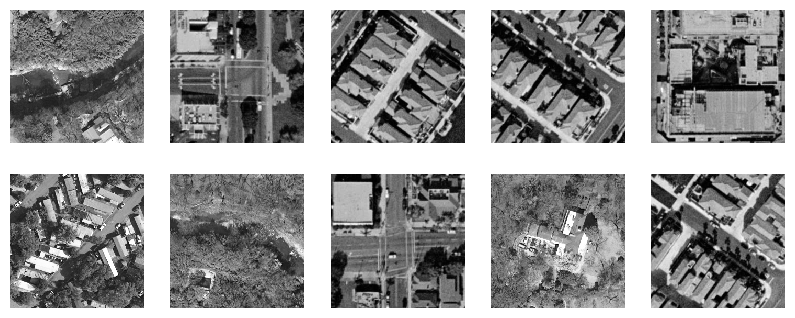

In [19]:
# Testing the Compute Similarity Function - SIFT x BoVW features
similarity_scores = compute_similarity(features_sift['river03'],features_sift, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images Similar to image 'river03' are as follows")

### Evaluation

##### Average Normalized Mean Retrieval Rank

In [20]:
def K(gt):
    return float(2*len(gt))

def MeanRank(ground_truth, retrieved):
    total_rank = 0.0
    gt_size = len(ground_truth)
    k = K(ground_truth)
    for image in ground_truth:
        position = retrieved.index(image)
        if(position > k):
            total_rank += 1.25*k
        else:
            total_rank += float(position)
    
    return total_rank/gt_size
        
def NMRR(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    mrr = MeanRank(ground_truth, retrieved) - 0.5*(1 + gt_size)
    if(mrr < 0):
        mrr = 0
    nmrr = mrr / (1.25*K(ground_truth) - 0.5*(1 + gt_size))
    
    return nmrr

# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def ANMRR(query_list, features_db):
    total_nmrr = 0.0
    for query in query_list:
        ground_truth = get_true_similar(query)
        gt_list = [k for k, v in ground_truth.items()]
        retrieved_dict = compute_similarity(features_db[query], features_db)
        retrieved_list = [k for k, v in retrieved_dict.items()]
        nmrr = NMRR(gt_list, retrieved_list)
        total_nmrr += nmrr
    return total_nmrr/float(len(query_list))
        
    
query_list = ['buildings03', 'beach03', 'airplane04']
anmrr = ANMRR(query_list, features_hog)
anmrr

0.8290598290598291

##### Mean Average Precision

In [21]:
def PatK(ground_truth, retrieved, k):
    true_positives = 0.0
    for i in range(k):
        if retrieved[i] in ground_truth:
            true_positives += 1
            if i == (k-1):
                precision = true_positives / float(k)
                return precision
        elif i == (k-1):
            return 0.0

def AP(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    retrieved_size = len(retrieved)
    
    total_precision = 0.0
    
    for i in range(1, retrieved_size):
        precision_at_k = PatK(ground_truth, retrieved, i)
        total_precision += precision_at_k
    return (total_precision/gt_size)
    
# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def MAP(query_list, features_db):
    total_AP = 0.0
    for query in query_list:
        ground_truth = get_true_similar(query)
        gt_list = [k for k, v in ground_truth.items()]
#         print(query)
        retrieved_dict = compute_similarity(features_db[query], features_db)
#         print(len(retrieved_dict))
        retrieved_list = [k for k, v in retrieved_dict.items()]
        average_precision = AP(ground_truth, retrieved_list)
        total_AP += average_precision
    return total_AP / float(len(query_list))
        
query_list = ['buildings03', 'beach03', 'airplane03']
mean_average_precision = MAP(query_list,features_sift)
mean_average_precision

0.20959657969380843

In [22]:
# Testing to see if Average Precision is working by altering the retrieved images
# Such that the ground_truth images are all on the top
def compute_fake_similarity(query_img_fv,features_db,dist='cosine'):
    all_similarity = None
    if dist == 'cosine':
        all_similarity = {filename:cosine_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    elif dist == 'euclidean':
        all_similarity = {filename:euclidean_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    
    #Sort Results
    all_rivers = ['river0'+str(i) for i in range(10)]
    for river in all_rivers:
        all_similarity[river] = 0.0

    sorted_all_similarity = sorted(all_similarity.items(), key=lambda kv: kv[1])
#     len(sorted_all_similarity)
    sorted_all_similarity = collections.OrderedDict(sorted_all_similarity)
    return sorted_all_similarity

def test_perfect():
    ground_truth = get_true_similar('river03')
    gt_list = [k for k, v in ground_truth.items()]
    retrieved_dict = compute_fake_similarity(features_hist['river03'], features_hist)
    retrieved_list = [k for k, v in retrieved_dict.items()]
    ap = AP(ground_truth, retrieved_list)
    nmrr = NMRR(ground_truth, retrieved_list)
    print("Average Precision is:", ap)
    print("NMRR is:", nmrr)

test_perfect()

Average Precision is: 1.0
NMRR is: 0.0


### Testing

In [23]:
def run_all(query_list, file_directory, descriptor='hist', similarity='cosine'):
    all_files = glob.glob(file_directory)
    all_images = {get_name(file):get_image(file) for file in all_files}

    features = get_features(all_images, descriptor)
    mean_average_precision = MAP(query_list, features)
    anmrr = ANMRR(query_list, features)
    print("Mean Average Precision is:", mean_average_precision)
    print("ANMRR is:", anmrr)


In [24]:
query_list = ['buildings02', 'beach03', 'airplane03']
file_directory = "./Smaller_Dataset/**/*.tif"

In [25]:
#Run Pipeline for Histogram features
run_all(query_list, file_directory,descriptor='hist')

Mean Average Precision is: 0.3423376263785085
ANMRR is: 0.5555555555555556


In [26]:
#Run Pipeline for HOG features
run_all(query_list, file_directory, descriptor='hog')

Mean Average Precision is: 0.16218323792033676
ANMRR is: 0.8290598290598291


In [27]:
#Run Pipeline for Local Histogram features
run_all(query_list, file_directory, descriptor='local_hist')

Mean Average Precision is: 0.38115094637777824
ANMRR is: 0.5162393162393163


In [28]:
#Run Pipeline for SIFT x BoVW features
run_all(query_list, file_directory, descriptor='sift')

Created a 3D matrix of: $(1028, 128, 210)
Mean Average Precision is: 0.21426093514171055
ANMRR is: 0.747008547008547
